In [1]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import theano.tensor as tt
from theano import shared
import pandas as pd
from matplotlib import gridspec
from sklearn.decomposition import PCA, KernelPCA
# from Plot_XZ import *
# from PCA import *

D:\Softwares\Python\Python_Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
plt.style.use('default')
font1 ={'family': 'times new roman', 'weight':'light', 'size': 12}  
# font2 ={'family': 'Arial', 'weight':'normal', 'size': 12}  
def Plot_XZ(elec_year, elec_faults, Savefig):
# 画出原始图
    Company_names = ['Xizang', 'Xinjiang', 'Heilongjiang']
    k = np.array([0, 41, 83])
    j= 0
    # j, k1 = 0, 6
    plt.figure(figsize=(4, 3), facecolor='w')

    ax = plt.subplot(1, 1, 1)
    for jx in range(7):
        ax.plot(elec_year[jx], elec_faults[jx], 'ko--', markersize=4, linewidth=1)
        # j = j+k1
    ax.set_xticklabels(['2016', '2010', '2011', '2012', '2013', '2014', '2015'], fontsize='small')
    ax.set_xlabel("time(year)", fontdict=font1)
    plt.ylabel("Failure rate(%)", fontdict=font1)
    plt.legend([Company_names[0]], loc='upper left', frameon=False, fontsize='small')
#     plt.grid()
    if Savefig == 1:
        plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\LOFG_BN\\Picture\\1.svg', format='svg')
    plt.show()
    plt.figure(figsize=(4, 3), facecolor='w')

    ax = plt.subplot(1, 1, 1)
    for jx in range(7, 18, 1):
        ax.plot(elec_year[jx], elec_faults[jx], 'ko--', markersize=4, linewidth=1)
        # j = j+k1
    ax.set_xticklabels(['2016','2010', '2011', '2012', '2013', '2014', '2015'], fontsize='small')
    ax.set_xlabel("time(year)", fontdict=font1)
    plt.ylabel("Failure rate(%)", fontdict=font1)
    plt.legend([Company_names[1]], loc='upper left', frameon=False, fontsize='small')
#     plt.grid()
    if Savefig == 1:
        plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\LOFG_BN\\Picture\\2.svg', format='svg')
    plt.show()
    
    plt.figure(figsize=(4, 3), facecolor='w')
    ax = plt.subplot(1, 1, 1)
    for jx in range(18, 25, 1):
        ax.plot(elec_year[jx], elec_faults[jx], 'ko--', markersize=4, linewidth=1)
        # j = j+k1
    ax.set_xticklabels(['2016','2010', '2011', '2012', '2013', '2014', '2015'], fontsize='small')
    ax.set_xlabel("time(year)", fontdict=font1)
    plt.ylabel("Failure rate(%)", fontdict=font1)
    plt.legend([Company_names[2]], loc='upper left', frameon=False, fontsize='small')
#     leg = plt.legend()
#     leg.get_frame().set_linewidth(0.0)
    
#     plt.grid()
    if Savefig == 1:
        plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\LOFG_BN\\Picture\\3.svg', format='svg')
    plt.show()
    return 0

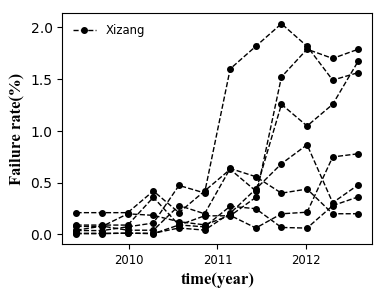

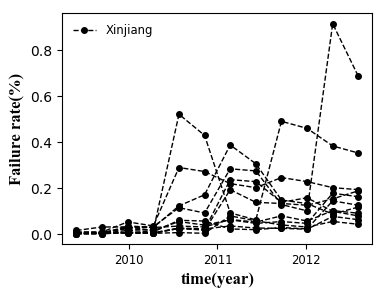

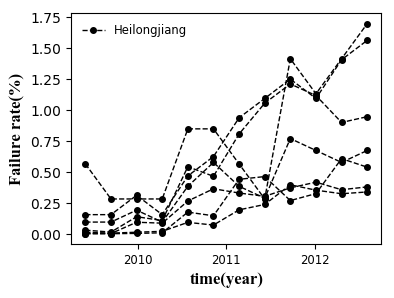

In [3]:
np.set_printoptions(precision=0, suppress=True)
Savefig = 0 # 控制图形显示存储

elec_data = pd.read_csv('XZnozero_12.csv')

# 计算同一公司产品测试地点数目：
companies_num = elec_data.counts.unique()
companies = len(companies_num)  # companies=7， 共7个测试地点
company_lookup = dict(zip(companies_num, range(len(companies_num))))
company = elec_data['company_code'] = elec_data.counts.replace(company_lookup).values  # 加一行数据在XZsingal文件中
# companys = elec_data.counts.values - 1 # 这一句以上面两行功能相同

# 计算不同公司数目
company_ABC = elec_data.company.unique()
companiesABC = len(company_ABC)  # companies=7， 共7个测试地点
company_lookup_ABC = dict(zip(company_ABC, range(len(company_ABC))))
companyABC = elec_data['company_ABC'] = elec_data.company.replace(company_lookup_ABC).values  # 加一行数据在XZsingal文件中
# companys = elec_data.counts.values - 1 # 这一句以上面两行功能相同
# elec_count = elec_data.counts.values

# 给所有特征因素加上高斯噪声
SNR = np.random.normal(0, 1, size=[len(elec_data.Year.values), 4])
SNR_Tem = np.random.normal(0, 1, size=[len(elec_data.Year.values), 1])
# #特征因素分析

elec_tem = elec_data.Tem.values + SNR_Tem[:, 0] # 观测温度值x2
elec_tem1 = (elec_tem - np.mean(elec_tem)) / np.std(elec_tem)
elec_hPa = elec_data.hPa.values + SNR[:, 1]  # 观测压强x3
elec_hPa1 = (elec_hPa - np.mean(elec_hPa)) / np.std(elec_hPa)
elec_RH = elec_data.RH.values + SNR[:, 2] # 观测压强x3
elec_RH1 = (elec_RH - np.mean(elec_RH)) / np.std(elec_RH)
elec_Lux = elec_data.Lux.values + SNR[:, 3] # 观测压强x3
elec_Lux1 = (elec_Lux - np.mean(elec_Lux)) / np.std(elec_Lux)


# 计算观测时间，温度，光照等环境条件
elec_year = elec_data.Year.values  # 观测时间值x1
Norm_year_Mean = np.mean(elec_year)
Norm_year_std = np.std(elec_year)
elec_year1 = (elec_year - np.mean(elec_year)) / np.std(elec_year)
data_cs_year = elec_year
# data_cs_year[42:45] = 12
# print(elec_year1)

elec_data.Fault.values[202] =200
elec_data.Fault.values[203] =150
# 计算故障率大小：故障数目/总测量数，作为模型Y值，放大100倍以增加实际效果，结果中要缩小100倍
elec_faults = 100 * (elec_data.Fault.values / elec_data.Nums.values)  # 数组形式,计算故障率大小
elec_faults1 = (elec_faults - np.mean(elec_faults)) / np.std(elec_faults)

# print(elec_faults)
# 将故障率以6组一行形式组成数组,变成：21*6
elec_faults2 = np.array([elec_faults[i*12:(i+1)*12] for i in np.arange(25)])
elec_year2 = np.array([elec_year1[i*12:(i+1)*12] for i in np.arange(25)])
elec_char1 = np.array([elec_tem1[i*12:(i+1)*12] for i in np.arange(25)])
elec_char2 = np.array([elec_hPa1[i*12:(i+1)*12] for i in np.arange(25)])
companyABC2 = np.array([companyABC[i*12:(i+1)*12] for i in np.arange(25)])

# 共享变量设置
xs_char1 = shared(np.asarray(elec_tem1))
xs_char2 = shared(np.asarray(elec_hPa1))
xs_char3 = shared(np.asarray(elec_RH1))

ys_faults = shared(np.asarray(elec_faults))
xs_year = shared(np.asarray(elec_year1))
Num_shared = shared(np.asarray(companyABC))
# print(companyABC)
# print(companiesABC)
# print(len(data_cs_year))
# print(len(elec_faults))
# 画图
Plot_XZ(elec_year2, elec_faults2, Savefig)


def logit(x):
    return 1/(1+np.exp(-x))
def tlogit(x):
    return 1/(1+tt.exp(-x))
def Phi(x):
    # probit transform
    return 0.5 + 0.5 * pm.math.erf(x/pm.math.sqrt(2))

In [4]:
# 相关系数计算,应用公式0.5*value+0.5可以将相关系数矩阵的值域由[-1,1]映射为[0,1]
All_data = np.vstack((elec_faults1,elec_year1, elec_tem1, elec_hPa1, elec_RH1)).T
print(All_data)
Cor_all = np.corrcoef(All_data, rowvar=0)
Cor_all = 0.5*Cor_all+0.5
print(Cor_all)
for i in np.arange(len(Cor_all)):
    print(Cor_all[0][i])
    print(Cor_all[1][i])
    print(Cor_all[2][i])
    print(Cor_all[3][i])
    print(Cor_all[4][i])

[[-1. -2. -1. -2.  1.]
 [-1. -1. -1. -2. -1.]
 [-1. -1. -1. -2.  1.]
 ...
 [ 2.  1.  1.  0.  0.]
 [ 3.  1.  0.  0.  1.]
 [ 3.  2.  1.  0.  0.]]
[[1. 1. 0. 0. 1.]
 [1. 1. 0. 1. 0.]
 [0. 0. 1. 1. 0.]
 [0. 1. 1. 1. 0.]
 [1. 0. 0. 0. 1.]]
0.9999999999999999
0.7374600235314777
0.4227377446415122
0.35389055980896444
0.6336980373474057
0.7374600235314777
1.0
0.470777234475233
0.5000857034195675
0.45468643475076614
0.4227377446415122
0.470777234475233
0.9999999999999999
0.9185182809089899
0.44354639187700406
0.35389055980896444
0.5000857034195675
0.9185182809089899
0.9999999999999999
0.39264988882694307
0.6336980373474057
0.45468643475076614
0.44354639187700406
0.39264988882694307
0.9999999999999999


In [ ]:
# 建模，模型
with pm.Model() as model_1:
    # define priors
    alpha = pm.HalfCauchy('alpha', 10, testval=.6)
    
    a0 = pm.Normal('a0', 0., 1.)
    σ_a = pm.HalfCauchy('σ_a', 2.)
    Δ_a = pm.Normal('Δ_a', 0., 20., shape=companiesABC)
    
    theta4 = pm.Normal('theta4', 0, 10)  
    mu_4 = pm.Normal('mu_4', mu=theta4, tau=0.001)
    sd_4 = pm.HalfCauchy('sd_4', 10)
    
    theta3 = pm.Normal('theta3', 0, 10)
    mu_3 = pm.Normal('mu_3', mu=theta3, tau=0.001)
    sd_3 = pm.HalfCauchy('sd_3', 10)
    
    theta2 = pm.Normal('theta2', 0, 10)
    mu_2 = pm.Normal('mu_2', mu=theta2, tau=0.001)
    sd_2 = pm.HalfCauchy('sd_2', 10)
    
    theta1 = pm.Deterministic('theta1', a0 + (σ_a*Δ_a).cumsum())

#     beta5 = pm.Normal('beta5', mu_5, sd_5, shape=companiesABC)  
    beta4 = pm.Normal('beta4', mu_4, sd_4, shape=companiesABC) 
    beta3 = pm.Normal('beta3', mu_3, sd_3, shape=companiesABC)
    beta2 = pm.Normal('beta2', mu_2, sd_2, shape=companiesABC)
#     beta1 = pm.Normal('beta1', mu_1, sd_1, shape=companiesABC)
    beta_sd = pm.HalfCauchy('beta_sd', 20)
    beta = pm.Normal('beta', 0, beta_sd)
    
    lam1 = pm.Exponential('lam1', lam=1)
    
    beta_mu = pm.Deterministic('beta_mu', 
                               tt.exp(beta + \
                                            (theta1[Num_shared] * xs_year + beta2[Num_shared] * xs_char1 + \
                                             beta3[Num_shared] * xs_char2 + beta4[Num_shared] * xs_char3)) )

    pois2 = pm.Weibull.dist(alpha=alpha, beta=beta_mu)  # 观测值
    pois1 = pm.Poisson.dist(mu=lam1)
    
    w = pm.Dirichlet('w', a=np.array([0.5, 1]))
    Observed = pm.Mixture('Observed', w=w, comp_dists = [pois1, pois2], observed=ys_faults)
    trace_1 = pm.sample(3000,  init='advi+adapt_diag' )

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = -178.67:  17%|████████▋                                         | 34891/200000 [01:02<04:53, 561.96it/s]
Convergence archived at 34900
Interrupted at 34,899 [17%]: Average Loss = -125.27
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
 12%|█████████▎                                                                     | 413/3500 [00:35<04:22, 11.75it/s]

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\stats.py:220: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


WAIC_r(WAIC=-479.63919189831347, WAIC_se=0.0, p_WAIC=6.8235887515919265)


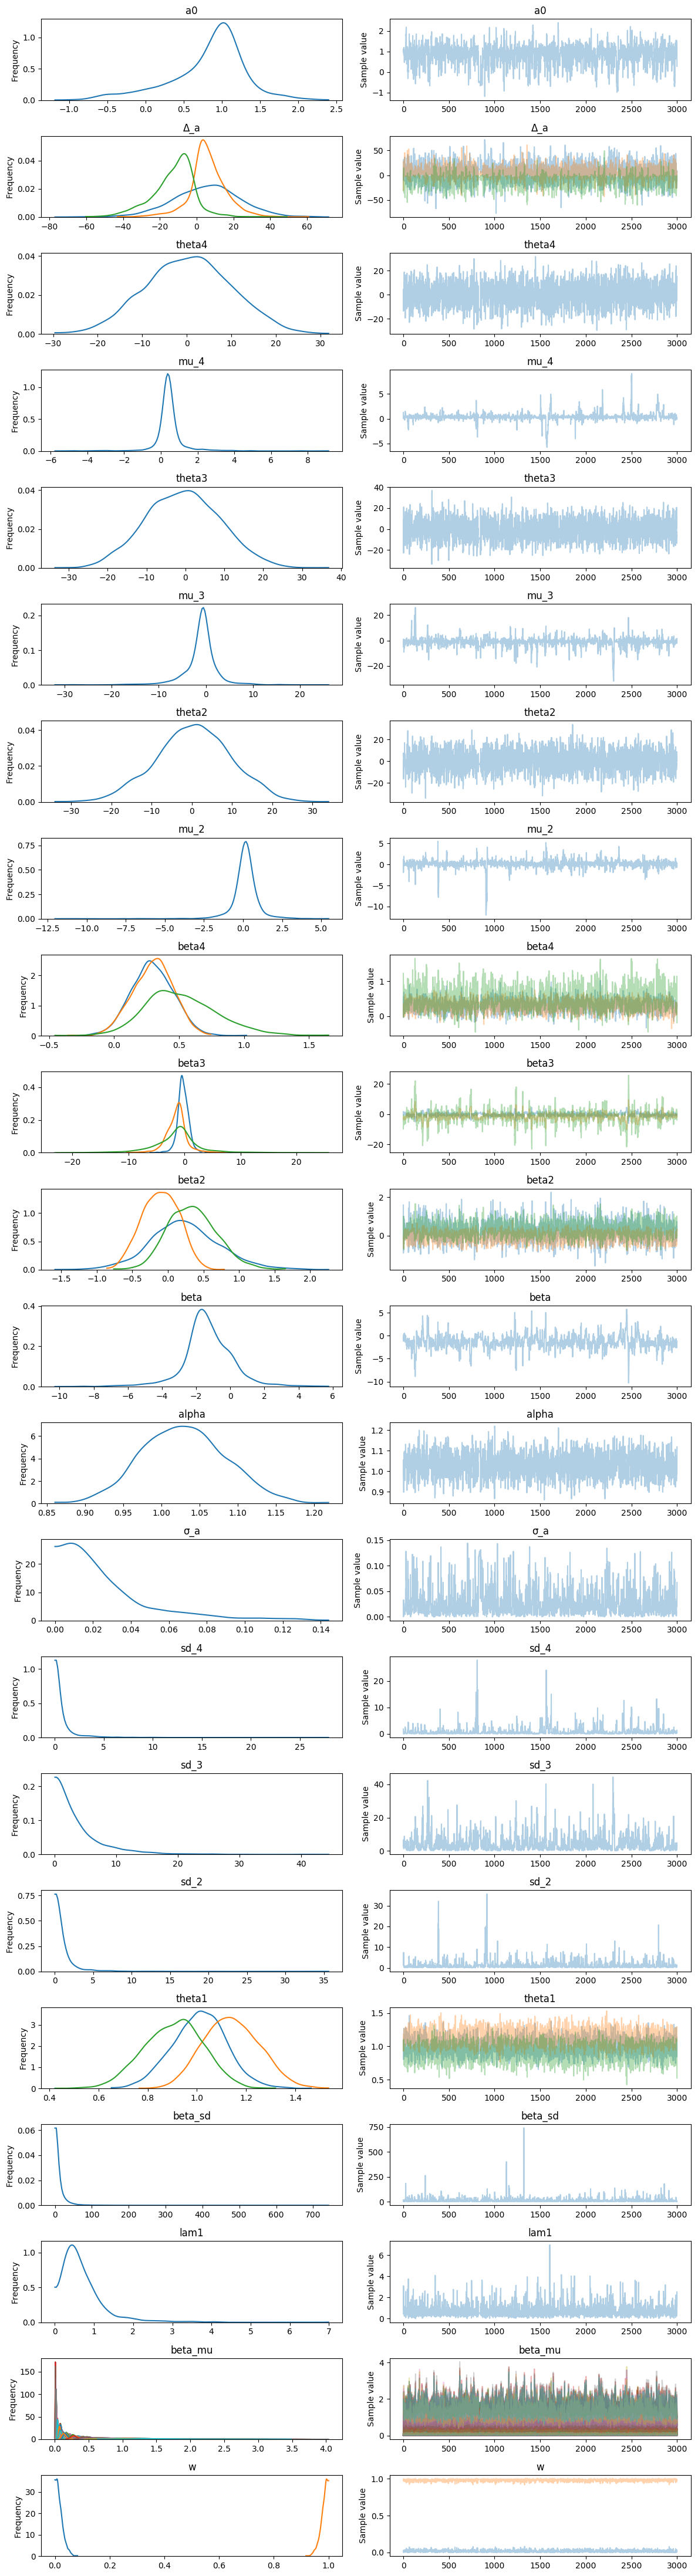

In [7]:
WAIC_1 = pm.waic(trace_1, model_1)
print(WAIC_1)
chain_1 = trace_1[1000:]
pm.traceplot(trace_1)
plt.show()

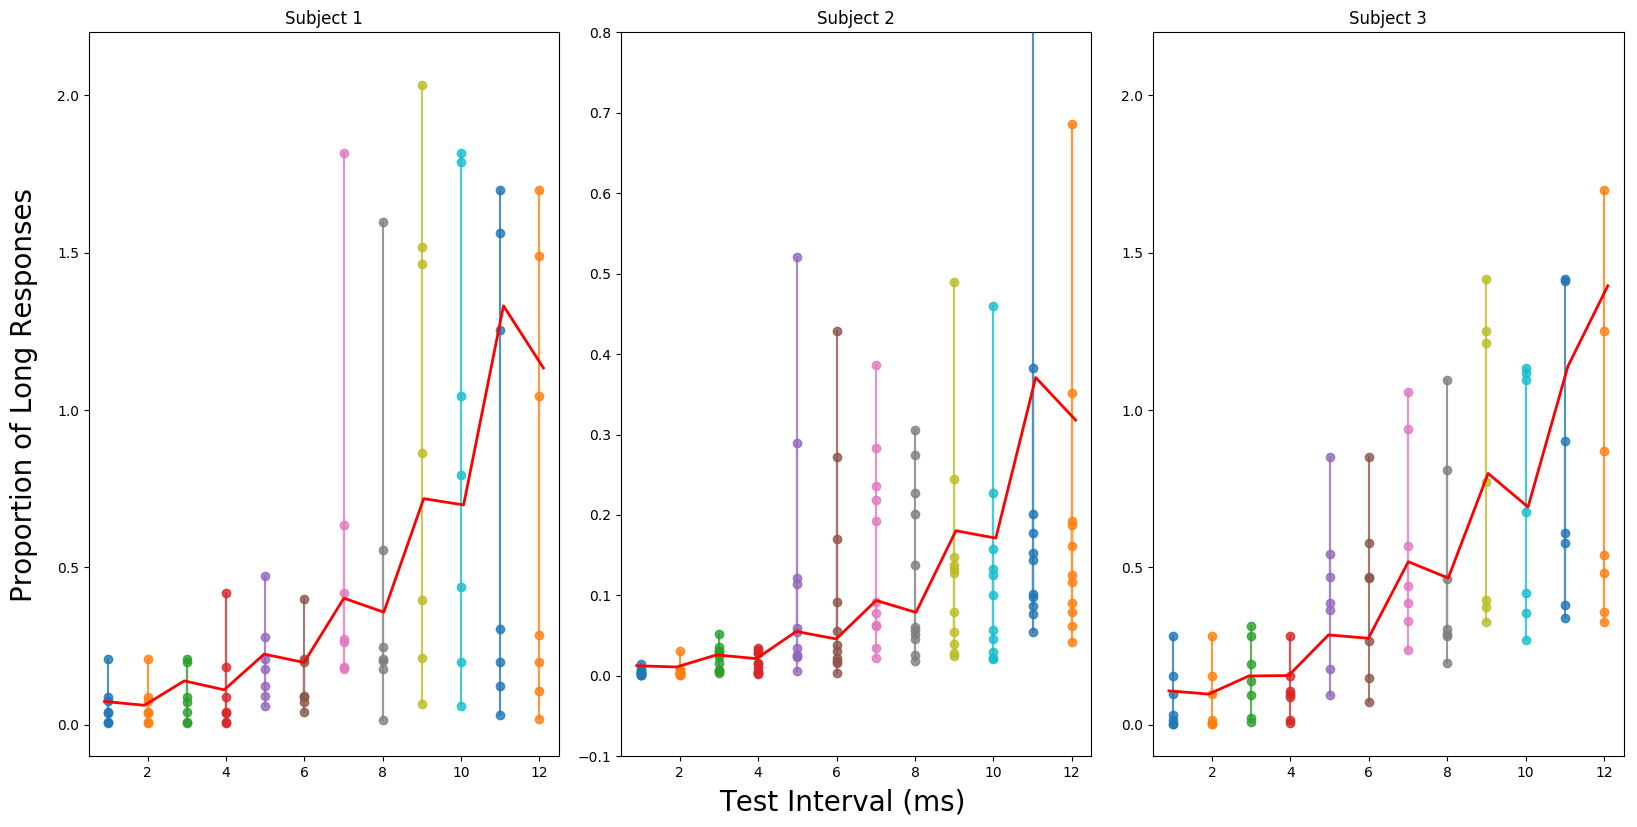

In [8]:
varnames1 = ['beta_mu']
tmp_mu1 = pm.df_summary(chain_1, varnames1)
Beta_Mu1 = tmp_mu1['mean']

Beta_Mu_1 = np.array([Beta_Mu1[i*12:(i+1)*12] for i in np.arange(21)])


fig = plt.figure(figsize=(16, 8))
fig.text(0.5, -0.02, 'Test Interval (ms)', ha='center', fontsize=20)
fig.text(-0.02, 0.5, 'Proportion of Long Responses', va='center', rotation='vertical', fontsize=20)
gs = gridspec.GridSpec(1, 3)
ppcsamples = 100


for ip in np.arange(companiesABC):
    ax = plt.subplot(gs[ip])
    xp = elec_year2[ip*7:(ip+1)*7, :]*Norm_year_std + Norm_year_Mean
    yp = elec_faults2[ip*7:(ip+1)*7, :]
    
    y2 = Beta_Mu_1[ip*7:(ip+1)*7, :]
    if ip==1:
        xp = elec_year2[ip*7:((ip+1)*7+4), :]*Norm_year_std + Norm_year_Mean
        yp = elec_faults2[ip*7:((ip+1)*7+4), :]
        y2 = Beta_Mu_1[ip*7:((ip+1)*7+4), :]
    if ip==2:
        xp = elec_year2[18:25, :]*Norm_year_std + Norm_year_Mean
        yp = elec_faults2[18:25, :]
        y2 = Beta_Mu_1[18:25, :]
    xl = np.linspace(0.9, 12.1, 12)

    
    y2 = y2.mean(axis=0)
#     print(y2)
    ax.plot(xp, yp, marker='o', alpha=.8)
    plt.plot(xl, y2,  'r', linewidth=2)
    plt.axis([0.5, 12.5, -.1, 2.2])
    if ip==1:
        plt.axis([0.5, 12.5, -.1, 0.8])
    plt.title('Subject %s' % (ip + 1))

plt.tight_layout()
plt.show()